# Digit Recognizer Kale Pipeline

In this [Kaggle competition](https://www.kaggle.com/competitions/digit-recognizer/overview) 

>MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

>In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.

# Install necessary packages

We can install the necessary package by either running `pip install --user <package_name>` or include everything in a `requirements.txt` file and run `pip install --user -r requirements.txt`. We have put the dependencies in a `requirements.txt` file so we will use the former method.

> NOTE: Do not forget to use the `--user` argument. It is necessary if you want to use Kale to transform this notebook into a Kubeflow pipeline

In [1]:
!pip install --user -r requirements.txt --quiet

# Imports

In this section we import the packages we need for this example. Make it a habit to gather your imports in a single place. It will make your life easier if you are going to transform this notebook into a Kubeflow pipeline using Kale.

In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import pickle
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras, optimizers
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import layers
print("tensorflow version: ", tf.__version__)

tensorflow version:  2.3.0


# Project hyper-parameters

In this cell, we define the different hyper-parameters. Defining them in one place makes it easier to experiment with their values and also facilitates the execution of HP Tuning experiments using Kale and Katib.

In [3]:
# Hyper-parameters
LR = 1e-3
EPOCHS = 2
BATCH_SIZE = 64
CONV_DIM1 = 56
CONV_DIM2 = 100

Set random seed for reproducibility and ignore warning messages.

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

# Setting the graph style
plt.rc('figure', autolayout=True)
plt.rc('axes', titleweight='bold', 
        titlesize=15)

plt.rc('font', size=12)

Download data

In [5]:
import zipfile
import wget

# path to download to
data_path = 'data'

# data link
train_link = 'https://github.com/josepholaide/KfaaS/blob/main/kale/data/train.csv.zip?raw=true'
test_link = 'https://github.com/josepholaide/KfaaS/blob/main/kale/data/test.csv.zip?raw=true'
sample_submission = 'https://raw.githubusercontent.com/josepholaide/KfaaS/main/kale/data/sample_submission.csv'

# download data
wget.download(train_link, f'{data_path}/train_csv.zip')
wget.download(test_link, f'{data_path}/test_csv.zip')
wget.download(sample_submission, f'{data_path}/sample_submission.csv')

with zipfile.ZipFile(f"{data_path}/train_csv.zip","r") as zip_ref:
    zip_ref.extractall(data_path)

with zipfile.ZipFile(f"{data_path}/test_csv.zip","r") as zip_ref:
    zip_ref.extractall(data_path)

# Load and preprocess data

In this section, we load and process the dataset to get it in a ready-to-use form by the model. First, let us load and analyze the data.

## Load data

The data are in `csv` format, thus, we use the handy `read_csv` pandas method. There is one train data set and two test sets (one public and one private).

In [6]:
data_path = 'data'

# Data Path
train_data_path = data_path + '/train.csv'
test_data_path = data_path + '/test.csv'
sample_submission_path = data_path + '/sample_submission.csv'


# Loading dataset into pandas 
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)
ss = pd.read_csv(sample_submission_path)

Let us now explore the data
To this end, we use the pandas `head` method to visualize the 1st five rows of our data set.

In [7]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data dimension
lets check train and test dimensions

In [8]:
train_df.shape, test_df.shape

((42000, 785), (28000, 784))

In [9]:
# join train and test together
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (70000, 785)


## Preprocess data

We are now ready to transform the data set and split the dataset into features and the target variables.

In [10]:
all_data_X = all_data.drop('label', axis=1)
all_data_y = all_data.label

In [11]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
all_data_X = all_data_X.values.reshape(-1,28,28,1)

# Normalize the data
all_data_X = all_data_X / 255.0

In [12]:
#Get the new dataset
X = all_data_X[:ntrain].copy()
y = all_data_y[:ntrain].copy()

In [13]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define and train the model

we define models with convoolution and dropout layers in our model architecture

In [14]:
def build_model(hidden_dim1=int(CONV_DIM1), hidden_dim2=int(CONV_DIM2), DROPOUT=0.5):
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = hidden_dim1, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Conv2D(filters = hidden_dim2, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Conv2D(filters = hidden_dim2, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = "softmax")
    ])

    model.build(input_shape=(None,28,28,1))
    
    return model

In [15]:
model = build_model()

In [16]:
# display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 56)        1456      
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 56)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 100)       50500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 100)       90100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 78400)             0

We are now ready to compile and fit the model.

In [17]:
model.compile(optimizers.Adam(learning_rate=float(LR)), 
              loss=SparseCategoricalCrossentropy(), 
              metrics=SparseCategoricalAccuracy(name='accuracy'))

In [18]:
history = model.fit(np.array(X_train), np.array(y_train), 
                    validation_split=.1, batch_size=int(BATCH_SIZE), epochs=int(EPOCHS))

Epoch 1/2
532/532 [==============================] - 109s 205ms/step - loss: 0.2163 - accuracy: 0.9352 - val_loss: 0.0728 - val_accuracy: 0.9780
Epoch 2/2
532/532 [==============================] - 109s 204ms/step - loss: 0.0723 - accuracy: 0.9772 - val_loss: 0.0521 - val_accuracy: 0.9836


## Evaluate the model

Evaluate the model and print the results

In [19]:
# Evaluate the model and print the results
test_loss, test_acc = model.evaluate(np.array(X_test),  np.array(y_test), verbose=0)
print("Test_loss: {}, Test_accuracy: {} ".format(test_loss,test_acc))

Test_loss: 0.04940946400165558, Test_accuracy: 0.9833333492279053 


# Confusion matrix

In [20]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

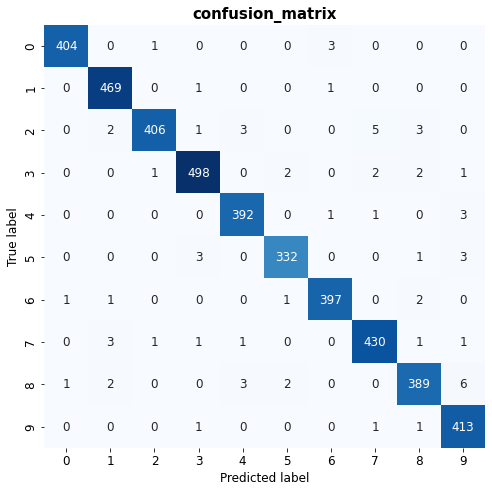

In [21]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,7))
sns.heatmap(cm, fmt='g', cbar=False, annot=True, cmap='Blues')
plt.title('confusion_matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Submission

Last but note least, we create our submission to the Kaggle competition. The submission is just a `csv` file with the specified columns.

In [22]:
test = all_data_X[ntrain:].copy()
submission_file = np.argmax(model.predict(test), axis=-1)
ss['Label'] = submission_file

In [23]:
ss.to_csv('sub.csv', index=False)
ss.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
